In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
import random
from multiprocessing.pool import ThreadPool
import time

import artifact
import sampler
import char
import damage
import stats
import solver
import analysis
from common import statnames, statmap, slotnames

from IPython import display

In [2]:
# lvl 90, talent lvl 9. weap=R5 L90 sharpshooter's
diona = [
    0, 9570,
    0, 601,
    0, 212 + 401,
    50, 500 + 469,
    0, 0,
    0, 0, 0, 0, 240, 0, 0, 0, 0,
]
diona = stats.Stats(np.array(diona, dtype=np.float32))

# Diluc base stats at A5 L80. With Lvl 90 prototype archaic.
#  Also crimson witch 4-set.
diluc = [
    0, 11453,
    0, 692,
    0 + 276, 295 + 565,
    50 + 144, 500,
    0, 0,
    0, 0, 0, 150, 0, 0, 0, 0, 0,
]
diluc = stats.Stats(np.array(diluc, dtype=np.float32))

n1 = damage.DilucN(0)
n2 = damage.DilucN(1)
n3 = damage.DilucN(2)
n4 = damage.DilucN(3)
n1q = damage.DilucN(0, q_infuse=True)
n2q = damage.DilucN(1, q_infuse=True)
n3q = damage.DilucN(2, q_infuse=True)
n4q = damage.DilucN(3, q_infuse=True)
q = damage.DilucQ()
e1 = damage.DilucE(0)
e2 = damage.DilucE(1)
e3 = damage.DilucE(2)

cw_buff = lambda x: damage.StatBuff(x, 'Pyro', .075)
q_buff = lambda x: damage.StatBuff(x, 'Pyro', .2)

vape = lambda f: damage.MultRxn(f, mult=1.5 * 1.15)  # crimson witch 15% bonus

tail = n1q + vape(n2q) + n3q + vape(n4q)
tail = vape(n1q + e3) + cw_buff(tail)
tail = n1q + vape(e2) + cw_buff(tail)
tail = vape(n1q + e1) + cw_buff(tail)
formula = vape(q) + q_buff(tail)

# formula = vape(q + n1 + e1) + n1 + vape(e2 + n1 + e3) + n1 + vape(n2) + n3 + vape(n4)
# formula = vape(q + n1q + e1 + e2 + n1q + e3 + n2q + n4q) + n1q + n1q + n3q

# formula =  damage.DilucN(0) + damage.DilucE(0) + damage.DilucN(0) + damage.DilucE(1)
# formula += damage.DilucN(0) + damage.DilucN(1) + damage.DilucE(1) + damage.DilucQ()
# formula =  damage.DilucN(0) + damage.DilucN(0) + damage.DilucN(0) + damage.DilucN(1)
# formula += damage.MultRxn(damage.DilucE(0) + damage.DilucE(1) + damage.DilucE(1) + damage.DilucQ())
# formula += damage.MultRxn(damage.DilucN(0, q_infuse=True) + damage.DilucN(2, q_infuse=True))
# formula += damage.DilucN(1, q_infuse=True) + damage.DilucN(3, q_infuse=True)
# sum(damage.DilucN(i, q_infuse=True) for i in range(4))
# formula = sum(damage.DilucN(i) for i in range(4))
c = char.Character(diluc, formula)

# formula = damage.DionaCharged(.5)
# c = char.Character(diona, formula)

In [3]:
thresh = 300000
def solve():
    slv = solver.Top1(diluc, formula)
    while slv.step() < thresh:
        pass
    return slv

with ThreadPool() as pool:
    t0 = time.time()
    results = []
    for _ in range(1000):
        results.append(pool.apply_async(solve))
        
    solns = []
    durs = []
    for i, r in enumerate(results):
        tstart = time.time()
        solns.append(r.get())
        durs.append(time.time() - tstart)
        if i % 10 == 0:
            display.display(f'iter {i}, dt: {time.time() - t0}')
            display.clear_output(wait=True)
    display.display(f'Total time: {time.time() - t0}')
    print(sum(durs))


iter 0, dt: 2.844583034515381
iter 10, dt: 8.699596881866455
iter 20, dt: 21.660290002822876
iter 30, dt: 22.053767919540405
iter 40, dt: 23.30176305770874
iter 50, dt: 27.914993047714233
iter 60, dt: 36.07973384857178
iter 70, dt: 39.80584096908569
iter 80, dt: 43.20510196685791
iter 90, dt: 51.1441011428833
iter 100, dt: 53.17913794517517
iter 110, dt: 60.491328954696655
iter 120, dt: 63.32545495033264
iter 130, dt: 68.15449595451355
iter 140, dt: 76.0265781879425
iter 150, dt: 76.43631601333618
iter 160, dt: 84.9290988445282
iter 170, dt: 91.94002985954285
iter 180, dt: 92.27883195877075
iter 190, dt: 97.39056396484375
iter 200, dt: 101.02997493743896
iter 210, dt: 107.66066408157349
iter 220, dt: 112.56740188598633
iter 230, dt: 114.39685797691345
iter 240, dt: 122.5767650604248
iter 250, dt: 124.12159514427185
iter 260, dt: 130.45990109443665
iter 270, dt: 137.2550048828125
iter 280, dt: 142.83214783668518
iter 290, dt: 147.98956680297852
iter 300, dt: 152.68345308303833
iter 310,

In [23]:
c.artis

Loadout(dmg=-1, artis=(None, None, None, None, None))

In [24]:
# c.artis = [None for _ in range(5)]
f'Base dmg: {c.eval()}'

'Base dmg: 45840.93515599214'

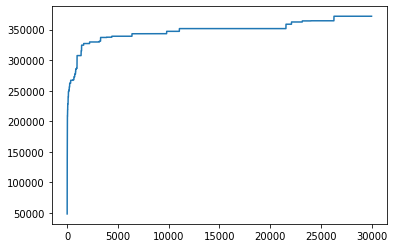

In [25]:
slv = solver.Top1(diluc, formula)
dmg = [slv.step() for _ in range(30000)]
plt.plot(dmg)

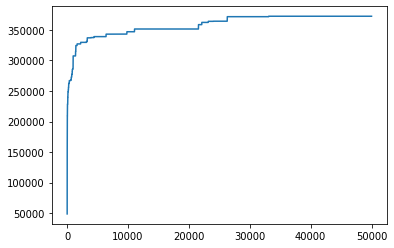

In [27]:
for _ in range(10000):
    dmg.append(slv.step())
plt.plot(dmg)

In [28]:
dmg[-1]

372525.95647169696

In [29]:
dmg[-1] * .8

298020.7651773576

In [13]:
np.argmax(np.array(dmg) > dmg[-1] * .8)

1625

In [30]:
# thresh = 100000
# thresh = 84000
thresh = 300000

outs = []
generated = []
for _ in range(1000):
    slv = solver.Top1(diluc, formula)
    while slv.step() < thresh:
        pass
    
    display.display(f'iter {_}, {len(slv.artis)}')
    display.clear_output(wait=True)
    
    outs.append(slv.top1)
    generated.append(slv.artis)

'iter 999, 1491'

804.771

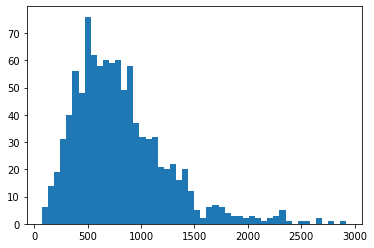

In [6]:
plt.hist(list(map(len, generated)), bins=50)
np.mean(list(map(len, generated)))

In [4]:
outs = []
generated = []
for s in solns:
    outs.append(s.top1)
    generated.append(s.artis)

In [5]:
anb1 = analysis.MainstatNB()
anb2 = analysis.SubstatNB()
anb3 = analysis.SubCountNB()

for o, g in zip(outs, generated):
    for a in g:
        anb1.summarize(a, a in o.artis)
        anb2.summarize(a, a in o.artis)
        anb3.summarize(a, a in o.artis)

In [62]:
for o in outs:
    if o.artis[3].main_stat == statmap['Pyro']:
        break

In [63]:
o

Loadout(dmg=330951.1168046932, artis=(HP Flower@(HP%:58>99, ATK%:47>88, CR:35>74, EM:23>69), ATK Feath@(HP%:58>58, CR:39>39, CD:54>256, EM:21>59), ATK% Sands@(HP:269>269, DEF%:51>51, CD:62>366, EM:23>42), Pyro Cup@(DEF:0>32, ATK%:47>194, ATK:18>18, EM:16>16), CR Hat@(HP%:41>129, ATK%:53>94, CD:70>148, EM:23>46)))

In [64]:
print('Artifact stat bonuses:')
for st in ['ATK', 'ATK%', 'CR', 'CD', 'Pyro']:
    print(f'{st}: {o._bake()[st]}')
    
c.equip(o)
print('\nfinal stats:')
for st in ['ATK', 'CR', 'CD', 'Pyro']:
    print(f'{st}: {c._bake_stats()[st]}')

Artifact stat bonuses:
ATK: 329.0
ATK%: 842.0
CR: 424.0
CD: 770.0
Pyro: 466.0

final stats:
ATK: 2150.47998046875
CR: 0.6179999709129333
CD: 1.2699999809265137
Pyro: 1.0410000085830688


In [11]:
slot = 4
statis = np.unique(np.array(list(anb1.slic(slot=slot).keys()))[:,1])
statis.sort()

nbsum4 = np.array([[anb1[slot, s, t] for t in [True, False]] for s in statis])
np.array(list(zip(list(map(statnames.__getitem__, statis)), *nbsum4.astype(str).T)))

array([['HP%', '0', '35461'],
       ['DEF%', '0', '35652'],
       ['ATK%', '309', '35216'],
       ['CR', '321', '15637'],
       ['CD', '208', '15834'],
       ['EM', '162', '6391'],
       ['Heal', '0', '16309']], dtype='<U5')

In [36]:
(nbsum4.T / np.sum(nbsum4, axis=1)).T

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.00932432, 0.99067568],
       [0.        , 1.        ],
       [0.0355712 , 0.9644288 ]])

In [16]:
slot = 4
statis = np.unique(np.array(list(anb3.slic(slot=slot).keys()))[:,1])
statis.sort()

nbsum4 = np.array([[anb3[slot, s, t] for t in [True, False]] for s in statis])
np.array(list(zip(statis, *nbsum4.astype(str).T)))

array([['3', '625', '128312'],
       ['4', '375', '32188']], dtype='<U21')

In [20]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/Users/albertxu/PycharmProjects/playground/Genshin/analysis.py'>

In [55]:
slot = 4
stats = np.unique(np.array(list(anb2.slic(slot=slot).keys()))[:,1])
stats.sort()

nbsum4 = np.array([[sum(anb2[slot, s, t].values()) for t in [True, False]] for s in stats])
list(zip(list(map(statnames.__getitem__, stats)), nbsum4))

[('HP%', array([  209, 21529])),
 ('HP', array([  304, 39046])),
 ('DEF%', array([  210, 21641])),
 ('DEF', array([  330, 38713])),
 ('ATK%', array([  499, 21161])),
 ('ATK', array([  462, 38670])),
 ('CR', array([  413, 19181])),
 ('CD', array([  479, 19210])),
 ('ER', array([  198, 27452])),
 ('EM', array([  214, 26526]))]

In [40]:
nb = nbsum4+1
list(zip(map(statnames.__getitem__, stats), *np.log(((nb.T)/ np.sum(nb, axis=1)))))

[('HP%', -4.639801629957732, -0.00970657031679176),
 ('HP', -4.859990301867764, -0.00778075074237004),
 ('DEF%', -4.6402353573940855, -0.009702340738558381),
 ('DEF', -4.770351730719712, -0.008513535391284363),
 ('ATK%', -3.7687067539734906, -0.02335245293157549),
 ('ATK', -4.43701987925181, -0.011901689231392142),
 ('CR', -3.857214768933151, -0.021353124470568946),
 ('CD', -3.7141308536432334, -0.024678646916727505),
 ('ER', -4.934148512340663, -0.00722260648166775),
 ('EM', -4.823352614046948, -0.008072280969402417)]

In [90]:
mainstats_pos

[{1: 100}, {5: 100}, {4: 100}, {13: 100}, {6: 43, 7: 35, 4: 22}]

In [91]:
mainstats_neg

[{1: 8671},
 {5: 8614},
 {2: 2338, 9: 877, 4: 2193, 0: 2292, 8: 832},
 {13: 335,
  16: 412,
  4: 1899,
  12: 425,
  17: 439,
  0: 1776,
  14: 452,
  2: 1708,
  15: 419,
  11: 456,
  9: 208},
 {4: 1997, 2: 1962, 10: 865, 6: 841, 0: 1976, 7: 867, 9: 326}]

(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.,
         3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,
         1.,  0.,  1.,  1.]),
 array([  0.        ,   4.86666667,   9.73333333,  14.6       ,
         19.46666667,  24.33333333,  29.2       ,  34.06666667,
         38.93333333,  43.8       ,  48.66666667,  53.53333333,
         58.4       ,  63.26666667,  68.13333333,  73.        ,
         77.86666667,  82.73333333,  87.6       ,  92.46666667,
         97.33333333, 102.2       , 107.06666667, 111.93333333,
        116.8       , 121.66666667, 126.53333333, 131.4       ,
        136.26666667, 141.13333333, 146.        ]),
 <BarContainer object of 30 artists>)

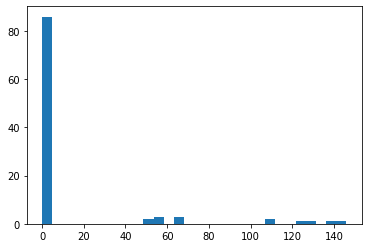

In [63]:
plt.hist(substats[:, 0, statmap['DEF%']], bins=30)

In [35]:
mainstats

array([[ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  6],
       [ 1,  5,  4, 13,  7],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  4],
       [ 1,  5,  4, 13,  6],
       [ 1,  5

In [31]:
np.unique(np.array(mainstats), axis=0, return_counts=True)

(array([[ 1,  5,  4, 13,  4],
        [ 1,  5,  4, 13,  6],
        [ 1,  5,  4, 13,  7]]),
 array([22, 43, 35]))

In [17]:
np.unique([o.artis[4].main_stat for o in outs], return_counts=True)

(array([4, 6, 7]), array([22, 43, 35]))

In [26]:
statnames[7]

'CD'

In [7]:
slv3 = solver.Top1(diluc, formula)
vss3 = [slv3.step() for _ in range(30000)]

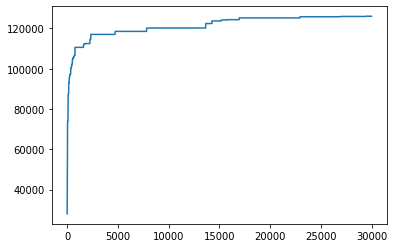

In [8]:
plt.plot(vss3)

In [9]:
slv3.top1

Loadout(dmg=126042.26506664866, artis=(HP Flower@(ATK%:41>41, CR:39>109, CD:78>280, EM:16>16), ATK Feath@(HP:299>299, ATK%:53>106, CR:39>39, CD:70>334), ATK% Sands@(ATK:16>16, CR:39>101, CD:62>256, EM:21>21), Pyro Cup@(DEF:21>21, CR:31>97, CD:0>226, ER:65>65), CR Hat@(DEF:19>19, ATK%:41>88, ATK:16>44, CD:62>202)))

In [10]:
print(slv3.c._bake_stats()['ATK'])
print(slv3.c._bake_stats()['CR'])
print(slv3.c._bake_stats()['CD'])
print(slv3.c._bake_stats()['Pyro'])

2071.22
0.851
1.798
0.466


In [61]:
formula = damage.DionaCharged(1)
slv2 = solver.Top1(diona, formula)
vss2 = [slv2.step() for _ in range(2000)]

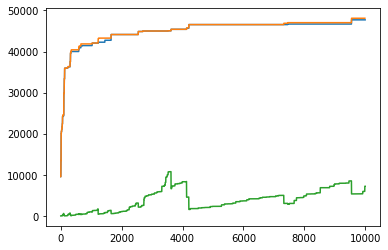

In [70]:
random.seed(1)
np.random.seed(1)
slv4 = solver.TopPerc(diluc, formula, perc=.95)
vss4 = []
for _ in range(10000):
    vss4.append(slv4.step())
    if _ % 10 == 0:
        if _ > 1000:
            plt.clf()
            plt.plot(vss3[:10+len(vss4)])
            plt.plot(vss4)
            display.display(plt.gcf())
        display.display(_)
        display.display(f'Hist len: {len(slv4.history_full[-1])}')
    
    display.clear_output(wait=True)
plt.plot(list(map(len, slv4.history_full)))

In [79]:
plt.plot(list(map(len, slv4.history_full)))

NameError: name 'slv4' is not defined

In [77]:
vss4_sav = vss4

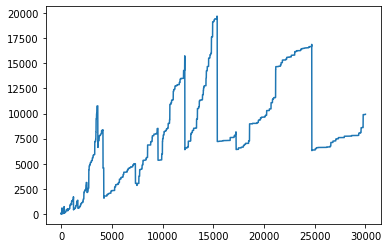

In [78]:
vss4 = list(vss4)
for _ in range(10000, 30000):
    vss4.append(slv4.step())
    if _ % 10 == 0:
        plt.clf()
        plt.plot(vss3[:10+len(vss4)])
        plt.plot(vss4)
        display.display(plt.gcf())
        display.display(_)
        display.display(f'Hist len: {len(slv4.history_full[-1])}')
    
    display.clear_output(wait=True)
plt.clf()
plt.plot(list(map(len, slv4.history_full)))

In [78]:
vss4_sav

NameError: name 'vss4_sav' is not defined

In [72]:
vss3 = np.array(vss3)
vss4 = np.array(vss4)

In [76]:
# plt.plot(vss3)
# plt.plot(vss4)
plt.plot((vss4 - vss3[:10000]) / vss3[:10000])

NameError: name 'vss4' is not defined

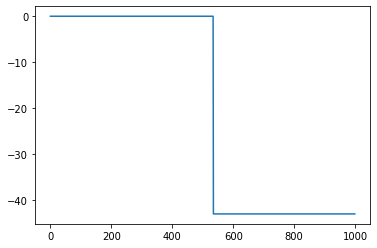

In [42]:
plt.plot(np.subtract(vss2, vss3))

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

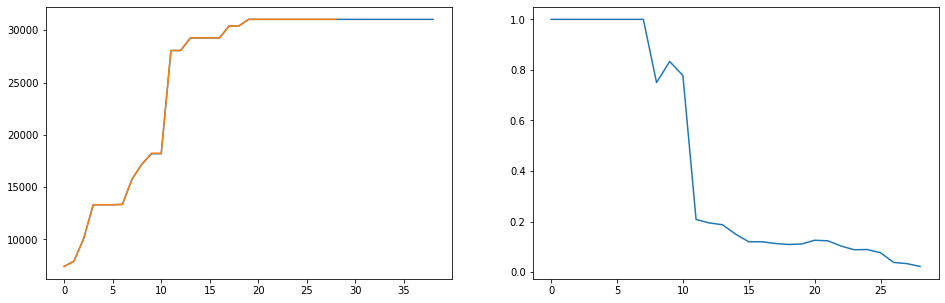

In [267]:
random.seed(69)
np.random.seed(42)

slv1 = solver.BruteForce(base, formula)
vss1 = []
p2p2 = []
dmgs = []
for _ in range(200):
    vss1.append(slv1.step())
    
    # tracking i guess
    if _ != 0:
        cur = slv1.history_full[-1]
        prv = slv1.history_full[-2]
        
        p2p = []
        for ix, qq in enumerate(cur):
            if qq in slv1.history[-1]:
                pri = slv1.config_prior[qq]
                frm = prv.index(pri)
                nw = True
            else:
                frm = prv.index(qq)
                nw = False
            p2p.append((1+frm, 1+ix, nw))
        p2p2.append(p2p)
    
    dmgs.append(list(map(lambda x: x.dmg, slv1.history_full[-1])))
    
    plt.clf()
    plt.figure(figsize=(16,5))
    plt.subplot(121)
    plt.plot(vss2[:len(vss1)+10])
    plt.plot(vss1)
    
    plt.subplot(122)
    buddy = [np.count_nonzero(np.array(d) > .8*max(d)) for d in dmgs]
    notbuddy = [len(d) for d in dmgs]
    plt.plot(np.array(buddy) / np.array(notbuddy))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.clf()

In [217]:
dmgs = [list(map(lambda x: x.dmg, bub)) for bub in slv1.history_full]

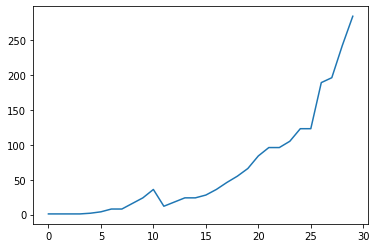

In [263]:
buddy = [np.count_nonzero(np.array(d) > .7*max(d)) for d in dmgs]
plt.plot(buddy)

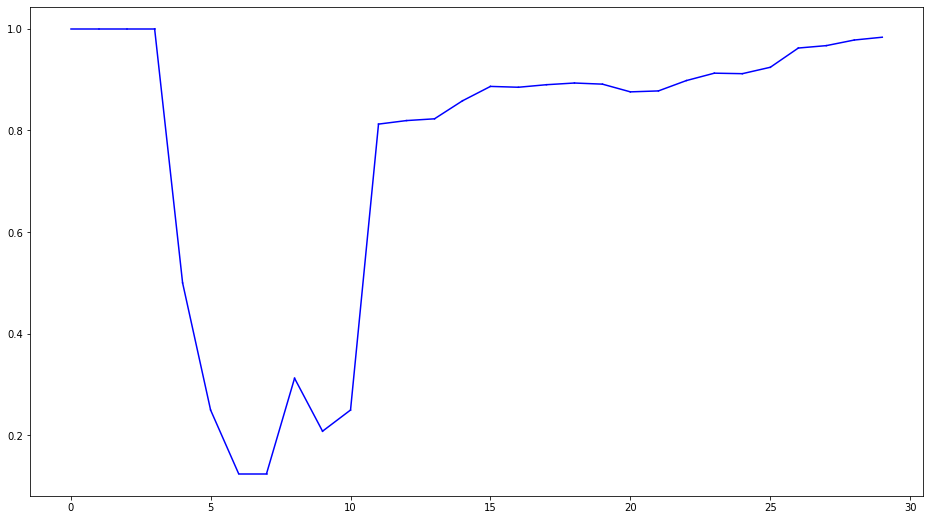

In [258]:
plt.figure(figsize=(16,9))
for i, p2p in enumerate(p2p2[:30]):
    ar = np.array(p2p)
    ma, mb, _ = np.amax(ar, axis=0)
#     a, b, cl = ar.T
    
#     if np.count_nonzero(cl==0) != 0:
#         plt.plot([i,i+1], [(ma-a[cl==0]+1)/ma,(mb-b[cl==0]+1)/mb], c='black', linewidth=.5)
#     plt.plot([i,i+1], [(ma-a[cl==1]+1)/ma,(mb-b[cl==1]+1)/mb], c='red', linewidth=.5)

    plt.plot([i, i+1], [(1+ma-buddy[i])/ma, (1+mb-buddy[i+1])/mb], c='blue')


In [189]:
slv1.artis[11]

Phys Cup@(HP:0>717, DEF%:66>124, ATK:19>19, EM:19>40)

In [120]:
i = 16
tz = sorted(slv1.history[i], reverse=True)
ty = sorted(slv1.history_full[i-1], reverse=True)

bob = []
for qq in tz:
    pri = slv1.config_prior[qq]
    bob.append(ty.index(pri))


In [108]:
bob

[0]

In [57]:
sorted(slv1.history_full[11], reverse=True)[0]

Loadout(dmg=31040.050068661378, artis=(HP Flower@(DEF%:73>263, CR:39>66, CD:54>54, ER:58>116), ATK Feath@(HP%:58>58, DEF:23>42, CD:0>272, ER:45>45), ATK% Sands@(HP:239>538, DEF%:0>66, CR:31>97, CD:70>148), Phys Cup@(HP:0>717, DEF%:66>124, ATK:19>19, EM:19>40), CR Hat@(HP:0>448, DEF%:51>109, ATK%:41>88, CD:54>116)))

In [51]:
slv1.config_prior[tz]

Loadout(dmg=28061.500415036757, artis=(HP Flower@(HP%:58>99, DEF%:73>124, ATK%:0>47, ER:45>175), ATK Feath@(HP%:47>88, DEF:21>21, ATK%:41>210, EM:0>21), ATK% Sands@(DEF:23>23, ATK:18>34, CD:70>132, EM:0>58), Phys Cup@(HP:0>717, DEF%:66>124, ATK:19>19, EM:19>40), CR Hat@(HP:0>448, DEF%:51>109, ATK%:41>88, CD:54>116)))

In [39]:
sorted(slv1.history[12], reverse=True)[0]

Loadout(dmg=27391.65909456837, artis=(HP Flower@(HP%:58>99, DEF%:73>124, ATK%:0>47, ER:45>175), ATK Feath@(HP:269>807, DEF%:51>51, DEF:16>35, CD:54>178), ATK% Sands@(DEF:23>23, ATK:18>34, CD:70>132, EM:0>58), Phys Cup@(HP:0>717, DEF%:66>124, ATK:19>19, EM:19>40), CR Hat@(HP:0>448, DEF%:51>109, ATK%:41>88, CD:54>116)))

In [34]:
sorted(slv1.history_full[11])

5376

In [83]:
anal = sorted(slv1.combos, reverse=True)

In [86]:
zz = np.array([a.dmg for a in anal])

(array([1.1130e+03, 7.3000e+03, 1.4404e+04, 1.4914e+04, 9.9830e+03,
        9.5080e+03, 1.6737e+04, 2.3985e+04, 2.2903e+04, 1.5834e+04,
        1.1158e+04, 1.0992e+04, 1.2235e+04, 1.1790e+04, 9.8950e+03,
        7.3290e+03, 5.8250e+03, 4.5220e+03, 3.9960e+03, 3.4880e+03,
        3.1980e+03, 2.8410e+03, 2.5360e+03, 2.1460e+03, 1.7860e+03,
        1.8590e+03, 1.4850e+03, 1.3520e+03, 1.0540e+03, 9.8600e+02,
        6.7900e+02, 6.8000e+02, 5.8400e+02, 4.2000e+02, 5.0000e+02,
        3.4700e+02, 3.1700e+02, 3.0600e+02, 2.4100e+02, 1.9600e+02,
        1.6100e+02, 9.1000e+01, 1.0800e+02, 4.0000e+01, 3.6000e+01,
        3.5000e+01, 1.3000e+01, 6.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([ 9554.1911431 , 10124.98436853, 10695.77759397, 11266.57081941,
        11837.36404485, 12408.15727028, 12978.95049572, 13549.74372116,
        14120.5369466 , 14691.33017204, 15262.12339747, 15832.91662291,
        16403.70984835, 16974.50307379, 17545.29629922, 18116.08952466,
        18686.8827501 , 19257.

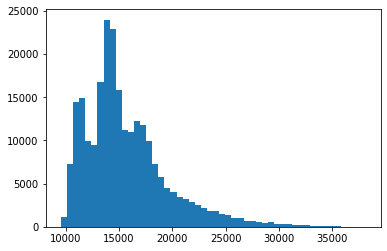

In [87]:
plt.hist(zz, bins=50)

In [73]:
for _ in range(20):
    f'Iter {len(vss1)}'
    vss1.append(slv1.step())

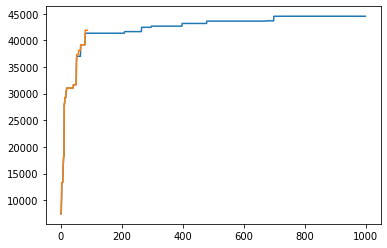

In [77]:
plt.plot(vss2)
plt.plot(vss1)

In [5]:
curves = []
c2 = []

In [24]:
c1 = []
random.seed(50)
np.random.seed(42)
for _ in range(20):
    slv = solver.Top1(base, formula)
    c1.append([slv.step() for _ in range(2000)])

In [25]:
c2 = []
random.seed(50)
np.random.seed(42)
for _ in range(20):
    slv = solver.Top2(base, formula)
    c2.append([slv.step() for _ in range(2000)])

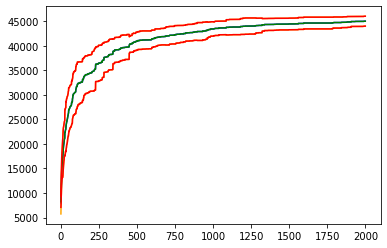

In [26]:
c1 = np.array(c1)
c2 = np.array(c2)

m1, s1 = np.mean(c1, axis=0), np.std(c1, axis=0)
m2, s2 = np.mean(c2, axis=0), np.std(c2, axis=0)
plt.plot(m1, color='b')
plt.plot(m1 + s1, color='orange')
plt.plot(m1 - s1, color='orange')
plt.plot(m2, color='green')
plt.plot(m2 + s2, color='red')
plt.plot(m2 - s2, color='red')

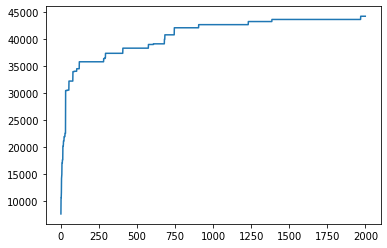

In [6]:
for _ in range(50):
    slv = solver.Top1(base, formula)
    vss = np.array([slv.step() for _ in range(2000)])
    curves.append(vss)
plt.plot(vss)

In [13]:
for _ in range(10):
    slv = solver.Top2(base, formula)
    vss2 = np.array([slv.step() for _ in range(2000)])
    c2.append(vss2)

TypeError: '<' not supported between instances of 'Artifact' and 'NoneType'

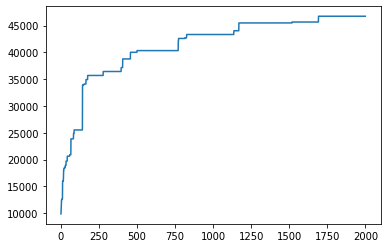

In [12]:
plt.plot(vss2)

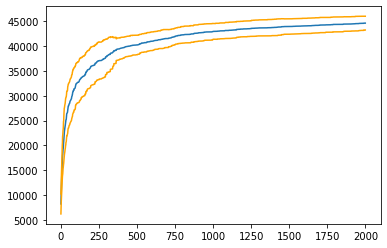

In [7]:
m1 = np.mean(curves, axis=0)
s1 = np.std(curves, axis=0)
plt.plot(m1)
plt.plot(m1 + s1, color='orange')
plt.plot(m1 - s1, color='orange')

In [5]:
class CumSolver:
    def __init__(self, stats, dmg):
        self.c = char.Character(stats, dmg)
        self.artis = []
        
        self.eqset = stats.Loadout()
        self.cur_dmg = self.c.eval()
        
        self.sets = {stats.Loadout()}
    
    def advance(self):
        a = artifact.make_arti()
        self.artis.append(a)
        
        # solver step
        self.c.equip(a)
        new_dmg = self.c.eval()
        if new_dmg >= self.cur_dmg:
            self.eqset = self.eqset.add(a)
            self.cur_dmg = new_dmg
        else:
            self.c.equip(self.eqset)
        return self.cur_dmg
    
    def solve_max(self, a):
        for s in self.sets:
            s[a.slot] 

In [37]:
np.argsort(vss[1:] - vss[:-1])[::-1]

array([ 112,   19,    1, ..., 1336, 1337,  999])

In [32]:
vss[112], vss[113]

(27286.364579186775, 31743.08867826028)

In [33]:
slv.artis[113]

Phys Cup@(HP:269>867, DEF:16>32, ER:0>110, EM:23>23)

In [95]:
eqset = [None for _ in range(5)]
c.artis = eqset.copy()
cur_dmg = c.eval()

artis = []
for _ in range(100):
    a = artifact.make_arti()
    artis.append(a)
    c.equip(a)
    
    new_dmg = c.eval()
    if new_dmg >= cur_dmg:
        eqset[a.slot] = a
        cur_dmg = new_dmg
    else:
        c.equip(eqset)
cur_dmg

34954.41928656727

In [96]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 34954.41928656727
  ATK: 2511.1201171875
  CR: 0.3840000033378601
  CD: 1.2380000352859497


[HP Flower@(DEF:0>21, ATK%:58>99, ATK:14>30, CD:62>186),
 ATK Feath@(HP%:41>41, ATK%:41>135, CR:0>97, ER:65>65),
 ATK% Sands@(HP%:53>53, ATK:0>28, CD:70>202, EM:16>39),
 Phys Cup@(HP:269>269, ATK:0>28, CD:62>132, ER:52>156),
 ATK% Hat@(HP:239>239, ATK:14>14, CR:27>93, CD:0>218)]

In [78]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 51990.25112449387
  ATK: 2194.360107421875
  CR: 0.8159999847412109
  CD: 1.8519999980926514


[HP Flower@(ATK%:41>152, ATK:18>18, CR:35>144, CD:54>54),
 ATK Feath@(ATK%:58>116, CR:31>62, CD:54>280, EM:19>19),
 ATK% Sands@(HP:209>209, DEF%:73>73, CR:27>101, CD:54>264),
 Phys Cup@(HP%:41>41, ATK:19>19, CR:35>179, CD:62>132),
 CD Hat@(DEF:16>39, ATK%:58>116, ATK:18>18, CR:39>136)]

In [74]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 52511.063832588814
  ATK: 2221.47998046875
  CR: 0.9480000138282776
  CD: 1.5880000591278076


[HP Flower@(DEF:19>19, ATK%:53>53, CR:39>179, CD:62>132),
 ATK Feath@(DEF:19>19, ATK%:58>163, CR:35>97, CD:70>132),
 ATK% Sands@(HP%:58>58, ATK:16>16, CR:35>179, CD:78>148),
 Phys Cup@(HP%:58>58, ATK%:47>163, CR:27>124, CD:54>54),
 CD Hat@(ATK%:47>47, ATK:16>30, CR:39>175, EM:23>23)]

In [65]:
print(f'Dmg: {c.eval(eqset)}')
eqset

Dmg: 53961.627858173


[HP Flower@(ATK%:53>53, ATK:18>18, CR:35>35, CD:70>428),
 ATK Feath@(DEF:21>21, ATK%:58>58, CR:35>132, CD:78>218),
 ATK% Sands@(HP:299>299, DEF:16>16, CR:27>105, CD:78>288),
 Phys Cup@(HP:239>239, ATK%:41>204, CR:39>109, CD:78>78),
 CR Hat@(HP%:58>58, ATK%:47>158, ATK:19>37, CD:70>202)]

In [70]:
c._bake_stats()

[0.0000000e+00 1.7435273e+04 0.0000000e+00 7.2900000e+02 0.0000000e+00
 2.2708999e+03 8.8599998e-01 1.7140000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.8300000e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]

In [14]:
%timeit c.eval()

173 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
a = artifact.make_arti()

In [12]:
a

ATK% Hat@(HP:0>418, DEF%:66>66, CD:54>240, EM:16>16)

In [10]:
c.artis[4] = a

In [2]:
a1 = artifact.make_arti()
a2 = artifact.make_arti()
a1, a2

(ATK% Sands@(HP%:58>198, DEF:19>19, CD:0>156, EM:23>23),
 CR Hat@(HP:239>508, DEF%:66>212, ATK:19>37, CD:70>124))

In [3]:
s = char.Stats()

In [5]:
a1 + a2

[198 508 212  19 466  37 311 280   0  23   0   0   0   0   0   0   0   0
   0]

In [47]:
%timeit artifact.make_arti()

137 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [1099]:
slotnames = ['Flower', 'Feath', 'Sands', 'Cup', 'Circ']
# statnames = ['CR', 'CD', 'ER', 'EM', 'ATK%', 'ATK', 'HP%', 'HP', 'DEF%', 'DEF', 'Heal',
statnames = ['HP%', 'HP', 'DEF%', 'DEF', 'ATK%', 'ATK', 'CR', 'CD', 'ER', 'EM', 'Heal',
          'Phys', 'Hydro', 'Pyro', 'Cryo', 'Electro', 'Anemo', 'Geo', 'Dendro']
statmap = {n: i for i, n in enumerate(statnames)}